﻿# 保存和加载模型

下面学习如何使用 PyTorch 保存和加载模型。我们经常需要加载之前训练过的模型，或继续用新的数据训练模型。所以这部分还是挺重要的。

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms

import helper
import fc_model

In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Processing...
Done!


下面是一个图像示例。

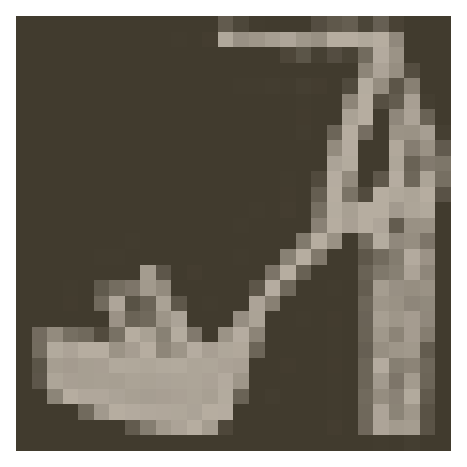

In [3]:
image, label = next(iter(trainloader))
helper.imshow(image[0,:]);

![png](output_4_0.png)


# 训练网络

我将上一部分的模型架构和训练代码移到了文件 `fc_model` 中。通过导入此模块，我们可以使用 `fc_model.Network` 轻松创建一个完全连接的网络，并使用 `fc_model.train` 训练网络。我会使用经过训练后的模型来演示保存和加载。

In [4]:
# Create the network, define the criterion and optimizer

model = fc_model.Network(784, 10, [512, 256, 128])
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [5]:
fc_model.train(model, trainloader, testloader, criterion, optimizer, epochs=2)

Epoch: 1/2..  Training Loss: 1.695..  Test Loss: 1.015..  Test Accuracy: 0.623
Epoch: 1/2..  Training Loss: 1.022..  Test Loss: 0.763..  Test Accuracy: 0.729
Epoch: 1/2..  Training Loss: 0.859..  Test Loss: 0.661..  Test Accuracy: 0.750
Epoch: 1/2..  Training Loss: 0.781..  Test Loss: 0.644..  Test Accuracy: 0.751
Epoch: 1/2..  Training Loss: 0.726..  Test Loss: 0.621..  Test Accuracy: 0.761
Epoch: 1/2..  Training Loss: 0.700..  Test Loss: 0.587..  Test Accuracy: 0.773
Epoch: 1/2..  Training Loss: 0.673..  Test Loss: 0.578..  Test Accuracy: 0.788
Epoch: 1/2..  Training Loss: 0.677..  Test Loss: 0.549..  Test Accuracy: 0.801
Epoch: 1/2..  Training Loss: 0.632..  Test Loss: 0.537..  Test Accuracy: 0.804
Epoch: 1/2..  Training Loss: 0.665..  Test Loss: 0.544..  Test Accuracy: 0.796
Epoch: 1/2..  Training Loss: 0.670..  Test Loss: 0.548..  Test Accuracy: 0.793
Epoch: 1/2..  Training Loss: 0.630..  Test Loss: 0.541..  Test Accuracy: 0.798
Epoch: 1/2..  Training Loss: 0.651..  Test Loss: 0.5

## 保存和加载网络

每次需要使用网络时都去训练它不太现实，也很不方便。我们可以保存训练过的网络，之后加载这些网络来继续训练或用它们进行预测。

PyTorch 网络的参数保存在模型的 `state_dict` 中。可以看到这个状态字典包含每个层级的权重和偏差矩阵。

In [6]:
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

Our model: 

 Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5)
) 

The state dict keys: 

 odict_keys(['hidden_layers.0.weight', 'hidden_layers.0.bias', 'hidden_layers.1.weight', 'hidden_layers.1.bias', 'hidden_layers.2.weight', 'hidden_layers.2.bias', 'output.weight', 'output.bias'])


最简单的方法是使用 `torch.save` 保存状态字典。例如，我们可以将其保存到文件 `'checkpoint.pth'` 中。

In [7]:
torch.save(model.state_dict(), 'checkpoint.pth')

然后，使用 `torch.load` 加载这个状态字典。

In [8]:
state_dict = torch.load('checkpoint.pth')
print(state_dict.keys())

odict_keys(['hidden_layers.0.weight', 'hidden_layers.0.bias', 'hidden_layers.1.weight', 'hidden_layers.1.bias', 'hidden_layers.2.weight', 'hidden_layers.2.bias', 'output.weight', 'output.bias'])


要将状态字典加载到神经网络中，需要执行 `model.load_state_dict(state_dict)`。

In [9]:
model.load_state_dict(state_dict)

看上去很简单？其实不然！只有模型结构和检查点的结构完全一样时，状态字典才能加载成功哦。如果我在创建模型时使用了不同的结构，便无法顺利加载。

In [10]:
# Try this
model = fc_model.Network(784, 10, [400, 200, 100])
# This will throw an error because the tensor sizes are wrong!
model.load_state_dict(state_dict)

RuntimeError: Error(s) in loading state_dict for Network:
	While copying the parameter named "hidden_layers.0.weight", whose dimensions in the model are torch.Size([400, 784]) and whose dimensions in the checkpoint are torch.Size([512, 784]).
	While copying the parameter named "hidden_layers.0.bias", whose dimensions in the model are torch.Size([400]) and whose dimensions in the checkpoint are torch.Size([512]).
	While copying the parameter named "hidden_layers.1.weight", whose dimensions in the model are torch.Size([200, 400]) and whose dimensions in the checkpoint are torch.Size([256, 512]).
	While copying the parameter named "hidden_layers.1.bias", whose dimensions in the model are torch.Size([200]) and whose dimensions in the checkpoint are torch.Size([256]).
	While copying the parameter named "hidden_layers.2.weight", whose dimensions in the model are torch.Size([100, 200]) and whose dimensions in the checkpoint are torch.Size([128, 256]).
	While copying the parameter named "hidden_layers.2.bias", whose dimensions in the model are torch.Size([100]) and whose dimensions in the checkpoint are torch.Size([128]).
	While copying the parameter named "output.weight", whose dimensions in the model are torch.Size([10, 100]) and whose dimensions in the checkpoint are torch.Size([10, 128]).

这就是说，我们需要重新构建和训练时完全一样的模型。我们需要将模型架构信息与状态字典一起保存在检查点里。所以，你需要创建一个字典，其中包含完全重新构建模型所需的所有信息。

In [11]:
checkpoint = {'input_size': 784,
              'output_size': 10,
              'hidden_layers': [each.out_features for each in model.hidden_layers],
              'state_dict': model.state_dict()}

torch.save(checkpoint, 'checkpoint.pth')

现在，检查点中包含了重建训练模型所需的全部信息。你可以随意将它编写为函数。同样，我们可以编写一个函数来加载检查点。

In [12]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = fc_model.Network(checkpoint['input_size'],
                             checkpoint['output_size'],
                             checkpoint['hidden_layers'])
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

In [13]:

model = load_checkpoint('checkpoint.pth')
print(model)


Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=200, bias=True)
    (2): Linear(in_features=200, out_features=100, bias=True)
  )
  (output): Linear(in_features=100, out_features=10, bias=True)
  (dropout): Dropout(p=0.5)
)
